# Neural Networks

This notebook presents the modeling of two problems using __neural networks__.

The structure of the notebook is the following.  We begin with a brief introduction to the theory behind neural networks.  (Even though the content of this first section is not explicitly used in the sections that follow, it helps one understand the rest of the notebook.)  Next, we use the `TensorFlow` library to model a concrete _regression problem_ via neural networks.  Then, we use the `PyTorch` library to model a concrete _classification problem_ via neural networks.  These two examples illustrate the structure of neural networks and the process involved in training them.

# Introduction

A _neural network_ is, essentially, a function $f : X \to Y$, which one usually _trains_ (or _fits_) to model the input-output (or feature-label) relation of a given dataset.  In this case, the domain of the neural network (the set $X$) should contain the features of the dataset, the codomain (the set $Y$) should contain the labels of the dataset, and the value of the neural network $f(x)$ on the feature $x$ of each data point should be as close as possible to its corresponding label.

The process of _training a neural network_ is a recursive algorithm that successively changes the function $f$ (or, more specifically, certain parameters of $f$ called _weights_ and _biases_) in such a way that, in subsequent steps, the neural network represents the feature-label relation of the dataset more accurately.

To measure this accuracy, one should choose a _loss function_.  This function, essentially, assesses the distance between the values of the neural network on the features of the data points and their corresponding labels.  Then, the goal of the training process is to minimize the total loss.

Hence the training of a neural network is, essentially, an optimization problem.  The objective of this optimization is to minimize the total loss, and the constraints are given by the restrictions that the parameters of the neural network (its weights and biases) must satisfy.  Notice that the parameters of the neural network (these weights and biases) become the variables of this optimization problem (the training of the neural network).

To solve this optimization problem, one usually uses a method called _gradient descent_.  This method relies on the fact that the gradient (or derivative) of a function points towards the direction in which the value of the function increases.  Thus, in order to minimize a function (the loss function, in our particular case), one should change its variables (the weights and biases of the neural network) in the direction opposite to the one given by its gradient (the gradient of the loss).

In summary, the process of training a neural network consists of the following steps.  First, apply the current iteration of the neural network to the features of the data points and calculate the total loss.  This part is called _forward pass_.  Then, change the weights and biases of the neural network in the direction opposite to the direction of the gradient of the loss.  This part is called _backward propagation_.  Repeat these steps for a predefined number of iterations (_epochs_), or until the total loss is close enough to zero.

To give an idea why the updating of the weights and biases of a neural network is called _backward propagation_, we will explain the structure of neural networks in more details.  As a bonus, these details will also provide an insight on the name _neural networks_.

There are several kinds of neural networks.  The simplest kind is called _multi-layer perceptron_ (or _fully connected neural network_, or _vanila neural network_).  In this simplest case, the function $f$ is in fact a composition of several functions,
$$
    f = f_n \circ f_{n-1} \circ \dots \circ f_2 \circ f_1.
$$
Each one of the functions $f_1, f_2, \dots, f_n$ is said to be a _layer_ of $f$.  Notice that the input-space of $f_1$ is the same as the input-space of $f$, which contains the features of the dataset.  Then, the output-space of $f_1$ is the input-space of $f_2$, and so on.  Each one of these input- and output-spaces can be further decomposed into smaller parts, which are called _neurons_.  This is the reason behind the name _neural network_.

Now, recall that the way the weights and biases of a neural network are updated is by changing them in the direction opposite to the direction of the gradient of the loss.  Also recall that the loss function takes into account values of $f$.  Hence, the gradient (derivative) of the loss function depends on the gradient (derivative) of $f$.  Since $f$ is a composition of the functions $f_1, f_2, \dots, f_n$, its derivatives are given by
$$
    \frac{df}{dx} = \frac{df_n}{df_{n-1}} \cdot \dots \cdot \frac{df_2}{df_1} \cdot \frac{df_1}{dx}
    \qquad \text{ (chain rule)}.
$$
This implies that one can compute the gradient of the loss by computing the derivative of each layer of the neural network in the reverse order (_backwards_): $\left. df_n \middle/ df_{n-1} \right.$ first and $\left. df_1 \middle/ dx \right.$ last.  This is the reason behind the name _backward propagation_.

In the following sections, we will use neural networks to model the relation between features and labels of very concrete datasets.

# Solving a regression problem with TensorFlow and Keras

<a name="constructing-the-data-set"></a>
## Constructing the data set

In [1]:
from random import uniform


# Choose the size of the data set.
s = 1000

# Construct a list of random numbers between 0 and 1.  These numbers are
# called the 'features' of the regression problem.
features = [uniform(-1, 1) for _ in range(s)]

# To construct the list of 'labels', that is, the images of the 'features',
# we will define a function.  This function is, essentially, the quadratic
# one f(x) = x^2, except for an added noise.  This noise can be interpreted
# as measurement errors of an experiment, for instance.
def f(x : float) -> float:
    noise = uniform(-0.1, 0.1)
    return x**2 + noise

# Using the function f (above), construct the 'labels' list.
labels = [f(x) for x in features]


### Plotting the data

To visualize the data that was constructed above, plot the pairs feature-label in the real plane $\mathbb{R}^2$.

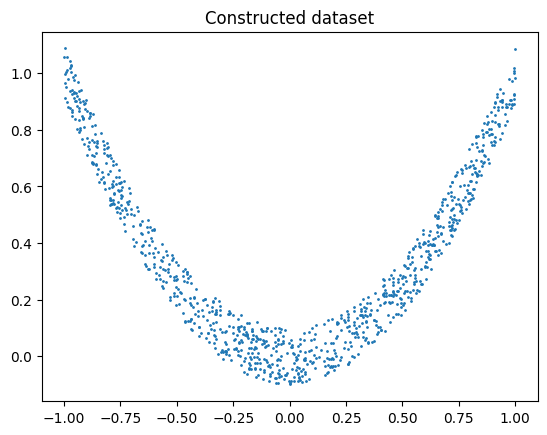

In [2]:
import matplotlib.pyplot as plt


# Plot the features in the x-axis, the labels in the y-axis, and set the size
# of the point markers to 1pt (to make it easier to see the points).
plt.title("Constructed dataset")
plt.scatter(features, labels, s=1)
plt.show()


### Splitting the data

The last step before training the models will be the splitting of the dataset (constructed above) into _training_ and _test_ subsets.  The _training subset_ will be used in the training phase, and the _test subset_ will be used in the evaluation phase.

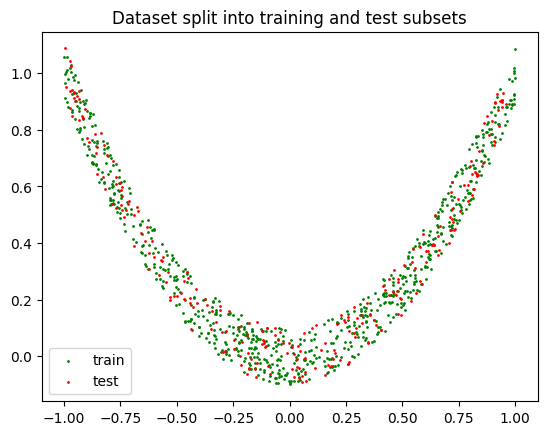

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split


# Separate the dataset into training and testing subsets.
x_train, x_test, y_train, y_test = train_test_split(features, labels, random_state=1)

# To visualize the diferent subsets, we will plot the points of the training
# set in green and the points of the test set in red.
plt.scatter(x_train, y_train, s=1, c='green', label="train")
plt.scatter(x_test, y_test, s=1, c='red', label="test")

# Show the graph.
plt.title("Dataset split into training and test subsets")
plt.legend()
plt.show()


## Training the neural network

Choose the architecture for the neural network.


In [8]:
from tensorflow import keras


# Begin by instantiating a multi-layer perceptron.
nn = keras.Sequential()

# Inform the dimension of the input-space: 1.
nn.add(keras.Input(shape=(1,)))

# Add a fully-connected layer with 8 neurons and activation function ReLU.
# (This activation function is what enables the model to learn non-linear
# functions, like x^2.)
nn.add(keras.layers.Dense(units=8, activation="relu"))

# Add an output layer with one neuron, the dimension of the output-space.
nn.add(keras.layers.Dense(units=1))

# Choose the loss function (mean squared error) and the optimizer (that is,
# the back propagation method, ADAM).
nn.compile(loss="mse", optimizer="adam")

# Print the summary.
nn.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8)                 16        
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


Now that the neural network is constructed, we can train (or _fit_) it.

In [9]:
# Training the model:

## x_train is the set of training features;
## y_train is the set of training labels;
## (x_test, y_test) is the validation data, used to evaluate the training;
## the forward passes will not evaluate the loss function on all the dataset,
##   but will split the training data in batches of 10 data points;
## the number of iterations (epochs) is set to 30.

nn_loss_history = nn.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=10, epochs=30, verbose=0)


### Evaluating the trained model

First, to detect if the model is underfitting or overfitting, we will plot the variation of the loss for each iteration (epoch) of the training process.  In this case, the graph shows that the model is training well, since both curves are approaching $0$ together.

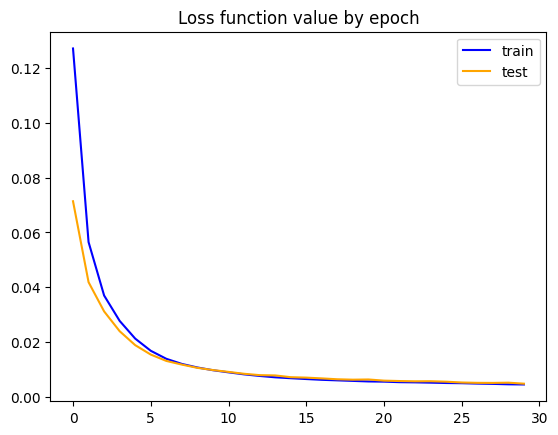

In [10]:
# Plot the progress of the training and test losses as the epochs advance.

plt.title("Loss function value by epoch")
plt.plot(range(30), nn_loss_history.history['loss'], color="blue", label='train')
plt.plot(range(30), nn_loss_history.history['val_loss'], color="orange", label='test')
plt.legend()
plt.show()


Next, we plot the trained model as a function.  Notice how close the fitted function (in red) is to the reference parabola (in green).

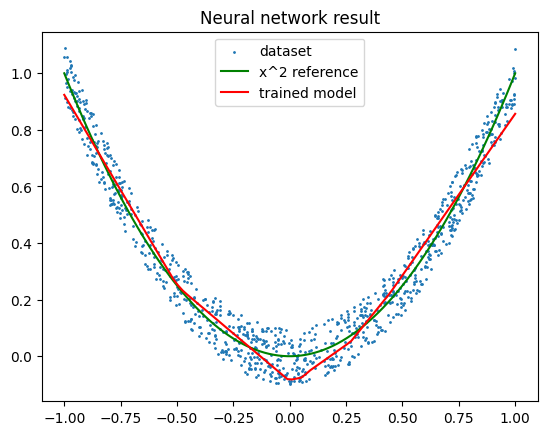

In [11]:
# For the x-axis, construct a grid of 100 points in the interval [-1.1, 1.1].
T = np.linspace(-1, 1, 100)

# For the y-axis, first construct the x^2 function, as a reference.
F = [t**2 for t in T]

# Then, also construct the result of trained model.
G = [nn.predict([[t]], verbose=0)[0,0] for t in T]


# Plot the dataset as a reference.
plt.scatter(features, labels, s=1, label='dataset')

# Plot the (x, x^2) points in green, as a reference.
plt.plot(T, F, color='green', label = 'x^2 reference')

# Plot the result of the neural network in red.
plt.plot(T, G, color='red', label = 'trained model')

# Show the graph.
plt.title("Neural network result")
plt.legend()
plt.show()


Lastly, we compute the _$R^2$ score_ and the _mean squared error_ of the trained model.  The relatively high $\text R^2$ score and relatively low mean squared error confirm that this model is well-fitted to the dataset.


In [12]:
from sklearn.metrics import mean_squared_error, r2_score


# Predict the value of the 'features' from the test subset, using the trained
# model.
y_predicted = [nn.predict([[x]], verbose=0)[0,0] for x in x_test]

# Calculate its R2 score.
r2s_test = r2_score(y_test, y_predicted)

# Calculate its mean squared error.
mse_test = mean_squared_error(y_test, y_predicted)


# Predict the value of the 'features' from the train subset, to check if the
# trained model is overfitting.
y_ev = [nn.predict([[x]], verbose=0)[0,0] for x in x_train]

# Calculate its R2 score.
r2s_train = r2_score(y_train, y_ev)

# Calculate its mean squared error.
mse_train = mean_squared_error(y_train, y_ev)


# Print the results.
print(f"R2: {r2s_test} (test), {r2s_train} (train)")
print(f"MSE: {mse_test} (test), {mse_train} (train)")


R2: 0.9506976956298513 (test), 0.9527130946887853 (train)
MSE: 0.004888489851972791 (test), 0.004508209452664155 (train)


Since the $\text R^2$ score of the neural network model on the test data subset is high (close to 1) and its mean squared error is low (close to 0), this method is having a good accuracy.  Moreover, since its $\text R^2$ scores and mean squared errors on the test and train data subsets are similar (and different from 1 and 0, respectively), we can also see that the trained model is not overfitting.


# Solving a classification problem with PyTorch

## Creating the data

In [13]:
from random import uniform


# Choose the size of our data set.
s = 1000

# Create the features (domain of the function): a list of pairs of random
# numbers, that is, a random subset of the Cartesian plane (R2).
features = [[uniform(0, 10), uniform(0, 10)] for _ in range(s)]

# To create the labels, we will use the following function.  This function
# determines if a number is greater than 5 or not.  In the first case, it
# returns 1, and in the second case, it returns 0.
def binary_class (x: float) -> int:
    if x > float(5):
        return 1
    else:
        return 0

# The next ingredient in the construction of the labels is an array of random
# numbers, which we can interpret as noise (for instance, in the measurements
# of a hypothetical experiment).
noise = [uniform(-1, 1) for _ in range(s)]

# The labels of our problem (image of our function) will be the result of
# applying the binary_class function to the "noisy average" of the coordinates
# of the feature points.  This "noisy average" is the average of the
# coordinates perturbed by adding the random noise.
labels = [ binary_class((features[i][0] + features[i][1])/2 + noise[i]) \
           for i in range(s) ]


<a name="plotting-the-data"></a>
### Plotting the data

To visualize the data that was created above, we will plot the points of the `feature` list in a $10 \times 10$ squared box, with the points that are labeled ${\color{red}0}$ colored in red, and the ones labeled ${\color{blue}1}$ colored in blue.

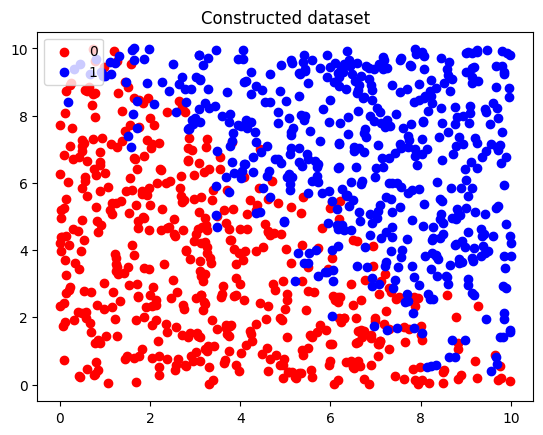

In [14]:
import matplotlib.pyplot as plt


# Collect the items in the 'feature' list that are labeled 0 and 1
# (respectively) in two separate numpy arrays.
zeros = np.array([features[i] for i in range(s) if labels[i] == 0])
ones = np.array([features[i] for i in range(s) if labels[i] == 1])

# To plot, create lists with the coordinates of the items (pairs) in the
# lists 'zeros' and 'ones'.
x_zeros = [x for (x, y) in zeros]
y_zeros = [y for (x, y) in zeros]
x_ones = [x for (x, y) in ones]
y_ones = [y for (x, y) in ones]

# Plot the items (points in R2) of the 'zeros' list in red and the items of
# the 'ones' list in blue.
plt.scatter(x_zeros, y_zeros, color='red', label='0')
plt.scatter(x_ones, y_ones, color='blue', label='1')

# Show the graph.
plt.title("Constructed dataset")
plt.legend()
plt.show()


## Training and evaluating a neural network

### Split the dataset

In [15]:
from sklearn.model_selection import train_test_split


# Split the data in two parts: training (67%) and test (33%).  The 'train'
# part will be used to train the model, and the 'test' part will be used to
# evaluate the model.
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=.33, random_state=1)


### Cast lists containing the data to PyTorch's `tensors`

In [16]:
import torch


# To train and evaluate the neural network, transform the following lists to
# PyTorch's tensors.
x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train).reshape(-1, 1)
x_test = torch.Tensor(x_test)


### Construct the neural network

In [17]:
# In PyTorch, one should construct neural networks by defining a subclass of
# the 'torch.nn.Module' class.

class NeuralNetwork (torch.nn.Module):
    def __init__ (self):
        super().__init__()
        self.architecture = torch.nn.Sequential(
            torch.nn.Linear(2, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 1),
            torch.nn.Sigmoid()
            )

    def forward (self, x):
        return self.architecture(x)


In [18]:
# Instantiating the neural network.
nn = NeuralNetwork()

# Choosing the loss function: binary cross entropy.
loss_function = torch.nn.BCELoss()

# Choosing the back propagation otimization method: SGD.
optimiser = torch.optim.SGD(nn.parameters(), lr=0.01)


### Train the neural network

In [19]:
number_epochs = 200

for _ in range(number_epochs):
    # Reset the gradient (otherwise it accumulates over time).
    optimiser.zero_grad()

    # Run one of the inputs through the network.
    forward_pass = nn(x_train)

    # Use the loss function to measure how far away the result of the forward
    # pass is from the data label.
    loss = loss_function(forward_pass, y_train)

    # Use backpropagation to update the model parameters.
    loss.backward()
    optimiser.step()


### Evaluate the trained model

In [20]:
from sklearn.metrics import classification_report


# To compute the predictions of the model: first turn the calculation of the
# gradients off (to save time), then apply the trained model to the test
# feature, extract the value from the PyTorch tensor, and round it to yield
# either 0 or 1.
with torch.no_grad():
    predictions = [round(nn(x).item()) for x in x_test]

# Print the 'classification report'.
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.90      0.22      0.36       167
           1       0.55      0.98      0.70       163

    accuracy                           0.59       330
   macro avg       0.73      0.60      0.53       330
weighted avg       0.73      0.59      0.53       330



## Tuning the hyper parameters

### Optimize the hyperparameters using `Optuna`

In [21]:
!pip install optuna --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.3/225.3 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.9 MB/s eta 0:00:00


In [36]:
# Define the objective function that will be optimized by Optuna, namely the
# accuracy of the neural network over the training data subset.
import optuna


def objective_function (trial):

    ## Instantiate the neural network.
    nn = NeuralNetwork()

    ## Set the range of parameters to be searched.
    backprop = trial.suggest_categorical('backprop', ['adam', 'sgd'])
    if backprop == 'adam':
        learning_rate = trial.suggest_float('lr', 0.001, 0.1)
        beta1 = trial.suggest_float('beta1', 0.01, 0.9)
        beta2 = trial.suggest_float('beta2', 0.001, 0.999)
        epsilon = trial.suggest_float('epsilon', 1e-10, 1e-01)
        optimiser = torch.optim.Adam(nn.parameters(), lr=learning_rate, betas=(beta1, beta2), eps=epsilon)
    else: # if backprop == 'sgd'
        learning_rate = trial.suggest_float('lr', 0.001, 0.1)
        momentum = trial.suggest_float('mu', 0, 1)
        dampening = trial.suggest_float('nu', 0, 1)
        optimiser = torch.optim.SGD(nn.parameters(), lr=learning_rate, momentum=momentum, dampening=dampening)

    ## Fit the neural network.
    loss_function = torch.nn.BCELoss()
    for _ in range(100):
        optimiser.zero_grad()
        forward_pass = nn(x_train)
        loss = loss_function(forward_pass, y_train)
        loss.backward()
        optimiser.step()

    ## Calculate the accuracy.
    with torch.no_grad():
        predictions = [round(nn(x).item()) for x in x_train]
    accuracy = classification_report(y_train, predictions, output_dict=True)['accuracy']

    return accuracy


In [37]:
# Create an Optuna object (called 'study') that is used to search for optimal
# hyperparameters.
study = optuna.create_study(direction='maximize')

# To prevent Optuna from printing the details of every step, set its verbosity
# to print only warnings.  Then, search for the optimal hyperparameters.
optuna.logging.set_verbosity(optuna.logging.WARNING)
_ = study.optimize(objective_function, n_trials=100)

# Print the hyperparameters obtained above.
print(study.best_trials[-1].params)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'backprop': 'adam', 'lr': 0.0644411019503004, 'beta1': 0.8722463928384866, 'beta2': 0.9614187808166219, 'epsilon': 0.00017375216441554119}


### Reset the hyperparameters and evaluate the trained model

In [38]:
# Instantiate the neural network.
nn = NeuralNetwork()

# Choose the loss function: binary cross entropy.
loss_function = torch.nn.BCELoss()

# Choose the back propagation otimization method using the hyper parameters
# obtained above.
optimiser = torch.optim.Adam(nn.parameters(), lr=0.06444, betas=(0.8722, 0.9614), eps=0.0002)


In [43]:
# Train the neural network:

number_epochs = 200

for _ in range(number_epochs):
    optimiser.zero_grad()
    forward_pass = nn(x_train)
    loss = loss_function(forward_pass, y_train)
    loss.backward()
    optimiser.step()


In [44]:
# Evaluate the trained model.

with torch.no_grad():
    predictions = [round(nn(x).item()) for x in x_test]

print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.87      0.87      0.87       167
           1       0.87      0.87      0.87       163

    accuracy                           0.87       330
   macro avg       0.87      0.87      0.87       330
weighted avg       0.87      0.87      0.87       330



In [41]:
# Compare the trained model to a reference goal: the naive separation of the
# feature points (x, y) that are above and below the line (x + y)/2 = 5.

y_reference = [1 if (x + y)/2 > 5 else 0 for (x, y) in x_test]
print(classification_report(y_test, y_reference))


              precision    recall  f1-score   support

           0       0.87      0.87      0.87       167
           1       0.87      0.87      0.87       163

    accuracy                           0.87       330
   macro avg       0.87      0.87      0.87       330
weighted avg       0.87      0.87      0.87       330



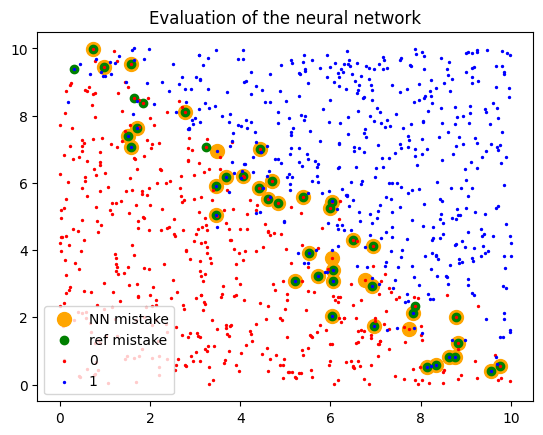

In [46]:
# Illustrate the comparisson between the trained model and the reference goal.

nn_wrong = [x_test[i] for i in range(len(x_test)) if y_test[i] != predictions[i]]
x_nn_wrong = [x for (x, y) in nn_wrong]
y_nn_wrong = [y for (x, y) in nn_wrong]

ref_wrong = [x_test[i] for i in range(len(x_test)) if y_test[i] != y_reference[i]]
x_ref_wrong = [x for (x, y) in ref_wrong]
y_ref_wrong = [y for (x, y) in ref_wrong]

plt.scatter(x_nn_wrong, y_nn_wrong, color='orange', s=100, label="NN mistake")
plt.scatter(x_ref_wrong, y_ref_wrong, color='green', label="ref mistake")
plt.scatter(x_zeros, y_zeros, color='red', s=2, label="0")
plt.scatter(x_ones, y_ones, color='blue', s=2, label="1")

plt.title("Evaluation of the neural network")
plt.legend()
plt.show()
